In [1]:
!pip install geopandas
!pip install folium
!pip install rtree

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 15.4 MB 34.0 MB/s 
     |████████████████████████████████| 6.3 MB 38.8 MB/s 
     |████████████████████████████████| 994 kB 4.8 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
from osgeo import osr, gdal
import numpy as np
from gdalconst import *
from shapely.geometry import Polygon, Point
import geopandas as gpd
import folium
import os
import rtree
from tqdm import tqdm
# import pygeos


def make_polygon_list(path, resume=None):
    """
    Creates GeoDataFrame, checks the tif files in a desired dir 
    and adds their geometries (with respective file name) as row
    to GeoDataFrame

    Parameters
    -----------

    path : (str)
        directory with tif files

    resume : (gpd.GeoDataFrame or None)
        if None: initializes new GeoDataFrame
        else: appends to given one

    Returns
    ----------
    coverage : gpd.GeoDataFrame
        df with geometries of tif files

    """

    tif_files = []

    # iterate over all .tif files in desired dir
    for filename in os.listdir(path):
        if filename.endswith(".tif"): 
            tif_files.append(os.path.join(path, filename))
    
    tif_files = [os.path.join(path, tif_file) for tif_file in tif_files]

    # add data to existing dataframe if desired
    if resume is None:
        coverage = gpd.GeoDataFrame({"filename": [], "geometry": []}).set_crs(epsg=4326)
    else:
        coverage = resume.set_crs(epsg=4326)

    # extract geometries of .tif files and add to geodataframe
    for file in tqdm(tif_files):
        info = gdal.Info(file, format="json")
        corners = info["cornerCoordinates"]
        poly = Polygon((
                    corners["upperLeft"],
                    corners["upperRight"],
                    corners["lowerRight"],
                    corners["lowerLeft"]
                        ))
        coverage = coverage.append({"filename": file, "geometry": poly}, ignore_index=True)

    return coverage


         


#%%
if __name__ == "__main__":

    base = '/content/drive/MyDrive/PyPSA_Africa_images/maxar'
    path_SL = os.path.join(base, 'sierra_leone/raw')
    path_GH = os.path.join(base, 'ghana/raw')
    path_MW = os.path.join(base, 'malawi/raw')
    path_TD = os.path.join(base, 'chad/raw')

    coverage = None
    for dir in [path_SL, path_GH, path_MW, path_TD]:
        coverage = make_polygon_list(dir, resume=coverage)

    # coverage = make_polygon_list(os.path.join(os.getcwd(), "images"))
    # coverage = make_polygon_list("./")
    # coverage.to_file("sierra_leone_coverage.json", driver="GeoJSON")
    # SL_RAW_TOWERS = os.path.join(os.path.dirname(os.getcwd()), "data", "SL_raw_towers.geojson")


100%|██████████| 6/6 [00:02<00:00,  2.33it/s]


In [4]:
import folium

# url = (
#     "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
# )
# antarctic_ice_edge = f"{url}/antarctic_ice_edge.json"
# antarctic_ice_shelf_topo = f"{url}/antarctic_ice_shelf_topo.json"

fn = 'tif_coverage.geojson'
coverage.to_file(fn, driver='GeoJSON')

m = folium.Map(
    location=[-59.1759, -11.6016],
    tiles="cartodbpositron",
    zoom_start=2,
)

folium.GeoJson(fn, name="geojson").add_to(m)

# folium.TopoJson(
#     json.loads(requests.get(antarctic_ice_shelf_topo).text),
#     "objects.antarctic_ice_shelf",
#    name="topojson",
# ).add_to(m)


m

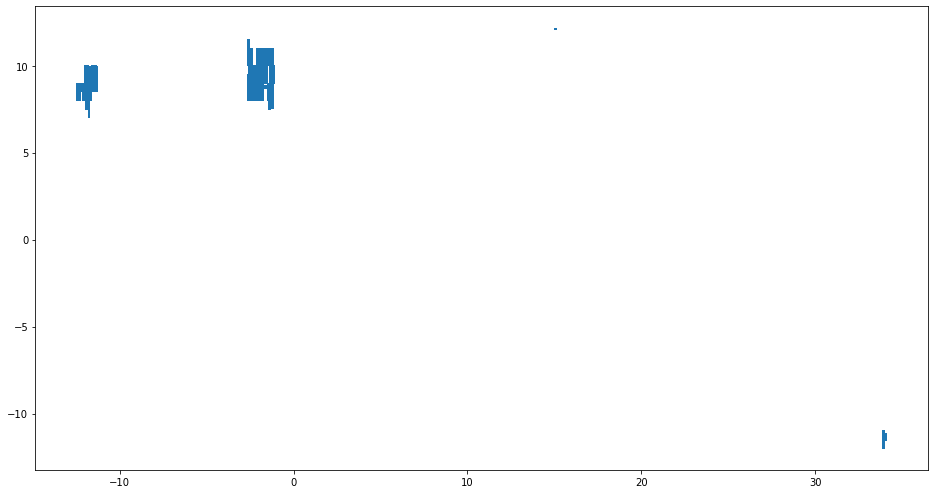

In [ ]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 1, figsize=(16, 9))
coverage.plot(ax=ax)
plt.show()

In [ ]:
towers_SL = os.path.join(base, "sierra_leone/raw/SL_raw_towers.geojson")
towers_SL = gpd.read_file(towers_SL)
towers_GH = os.path.join(base, "ghana/raw/GH_raw_towers.geojson")
towers_GH = gpd.read_file(towers_GH)


In [ ]:
hits_GH = gpd.sjoin(towers_GH, coverage, how="inner").set_crs(epsg=4326)
print(len(hits_GH))

hits_GH = hits_GH.drop(["index_right"], axis=1)

4547


In [ ]:
hits_GH.filename.unique()
max_imgs = 0
max_tif = None
for tif in hits_GH.filename.unique():
    # print(tif)
    curr = hits_GH.loc[hits_GH['filename'] == tif]
    # print(curr)
    if len(curr) > max_imgs:
        max_imgs = len(curr)
        max_tif = tif
    
print('max images')
print(max_imgs)
print('file')
print(max_tif)

max images
380
file
/content/drive/MyDrive/PyPSA_Africa_images/maxar/ghana/raw/10500100103B0300.tif


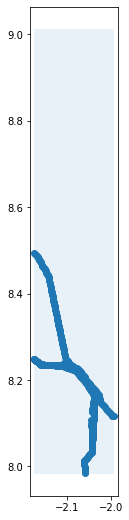

In [ ]:

_, ax = plt.subplots(1, 1, figsize=(16, 9))
hits_GH.loc[hits_GH['filename'] == max_tif].plot(ax=ax)
coverage.loc[coverage['filename'] == max_tif].plot(ax=ax, alpha=0.1)
plt.show()


In [ ]:
import cv2
from google.colab.patches import cv2_imshow()

for i, img in hits_GH.loc[hits_GH['filename'] == max_tif].iteritems


In [ ]:
path1 = 